# Topology optimization of the GE jet engine bracket challenge

The GE jet engine bracket challenge was a design challenge posted on GrabCAD [1].


[1] https://grabcad.com/challenges/ge-jet-engine-bracket-challenge

In [1]:
import meshio
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchfem import Solid
from scipy.optimize import bisect
from torchfem.materials import IsotropicElasticity3D
from torchfem.examples import get_example_file

torch.set_default_dtype(torch.float64)

In [2]:
# Material model (Ti-6Al-4V) in imperial units
material = IsotropicElasticity3D(E=16500.0, nu=0.342)

## Mesh 

The domain is meshed with linear tetrahedrons in gmsh and subdivided in seven geometrical domains.

In [3]:
mesh = meshio.read(get_example_file("ge_bracket.vtu"))
elements = torch.tensor(mesh.cells[0].data)
nodes = torch.tensor(mesh.points)
dom = torch.tensor(mesh.cell_data["gmsh:geometrical"][0])

model = Solid(nodes, elements, material)
cmap = plt.get_cmap("tab10", 7)
model.plot(element_property={"Domain": dom}, cmap=cmap)

Widget(value='<iframe src="http://localhost:51984/index.html?ui=P_0x31f649de0_0&reconnect=auto" class="pyvista…

In [4]:
interface_1 = torch.unique(elements[(dom == 2) | (dom == 7)])
interface_2 = torch.unique(elements[(dom == 1) | (dom == 3) | (dom == 4) | (dom == 5)])

# Design elements
design_elements = elements[dom == 6]

# Define load cases (this is not using multi-point constraints yet...)
load_case_1 = torch.zeros_like(nodes)
load_case_1[interface_1, 2] = 8000 / len(interface_1)
load_case_2 = torch.zeros_like(nodes)
load_case_2[interface_1, 1] = -8500 / len(interface_1)
load_case_3 = torch.zeros_like(nodes)
load_case_3[interface_1, 1] = -9500 * np.sin(np.deg2rad(42)) / len(interface_1)
load_case_3[interface_1, 2] = 9500 * np.cos(np.deg2rad(42)) / len(interface_1)
load_case_4 = torch.zeros_like(nodes)
levers = nodes[interface_1] - torch.tensor([0.0, 0.0, 0.0])
load_case_4[interface_1, 1] = 5000 / levers[:, 0] / len(interface_1)

# Apply load case 1
model.forces = load_case_3

# Constrained nodes at interface 2
model.constraints[interface_2, :] = True

# Solve
u, f, σ, ε, α = model.solve()

# Plot
model.plot(node_property={"u": u})

Widget(value='<iframe src="http://localhost:51984/index.html?ui=P_0x32a1e6a40_1&reconnect=auto" class="pyvista…

## Optimization parameters 
We define the optimization parameters, i.e. the volume fraction, the penalization factor, the move limit, the filter radius, and the number of iterations.

In [5]:
volfrac = 0.15
p = 3
move = 0.2
R = 5.0

In [6]:
B = model.etype.B(model.etype.ipoints())
J = torch.einsum("ijk,mkl->imjl", B, nodes[design_elements, :])
detJ = torch.linalg.det(J)
vols = torch.einsum("i,ij->ij", model.etype.iweights(), detJ).sum(dim=0)

In [8]:
# Initial, minimum, and maximum values of design variables
rho_0 = volfrac * torch.ones(len(design_elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = torch.ones_like(rho_0)

# Volume fraction
V_0 = volfrac * vols.sum()

# Analytical gradient of the stiffness matrix
k0 = model.k0()[dom == 6].clone()
C0 = model.material.C[dom == 6].clone()

# Precompute filter weights (in chunks and as sparse matrix to save memory)
ecenters = nodes[design_elements].mean(axis=1)
row = []
col = []
values = []
i = 0
for chunk in ecenters.chunk(1000):
    d = torch.cdist(chunk, ecenters)
    H = R - d
    mask = d < R
    r, c = torch.where(mask)
    row.append(r + i)
    col.append(c)
    values.append(H[mask])
    i += len(chunk)

row = torch.cat(row)
col = torch.cat(col)
values = torch.cat(values)

H = torch.sparse_coo_tensor(
    indices=torch.stack([row, col]),
    values=values,
    size=(len(design_elements), len(design_elements)),
)

H_sum = H.sum(dim=0).to_dense()

## Optimization with optimality constraints. 

This may take an hour to run. Performance optimization is pending...

In [9]:
rho = [rho_0]
history = []

# Iterate solutions
for k in tqdm(range(25)):
    # Adjust thickness variables
    model.material.C[dom == 6] = torch.einsum("j,jkl->jkl", rho[k] ** p, C0)

    sensitivity = torch.zeros_like(rho[k])
    # Iterate over load cases
    for lc in [load_case_1, load_case_2, load_case_3, load_case_4]:
        # Apply load case
        model.forces = lc
        # Compute solution
        u_k, f_k, _, _, _ = model.solve()
        # Evaluation of compliance
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        # Compute analytical sensitivities
        u_j = u_k[design_elements].reshape(len(design_elements), -1)
        w_k = torch.einsum("...i, ...ij, ...j", u_j, k0, u_j)
        sensitivity += -p * rho[k] ** (p - 1.0) * w_k

    # Filter sensitivities (if r provided)
    sensitivity = H @ (rho[k] * sensitivity / vols) / H_sum / (rho[k] / vols)

    # For a certain value of mu, apply the iteration scheme
    def make_step(mu):
        G_k = -sensitivity / mu
        upper = torch.min(rho_max, (1 + move) * rho[k])
        lower = torch.max(rho_min, (1 - move) * rho[k])
        rho_trial = G_k**0.5 * rho[k]
        return torch.maximum(torch.minimum(rho_trial, upper), lower)

    # Constraint function
    def g(mu):
        rho_k = make_step(mu)
        return torch.inner(rho_k, vols) - V_0

    # Find the root of g(mu)
    with torch.no_grad():
        mu = bisect(g, 1e-10, 100.0)

    # Update design history
    rho.append(make_step(mu))
    history.append(compliance)

100%|██████████| 25/25 [1:10:50<00:00, 170.03s/it]


## Postprocessing

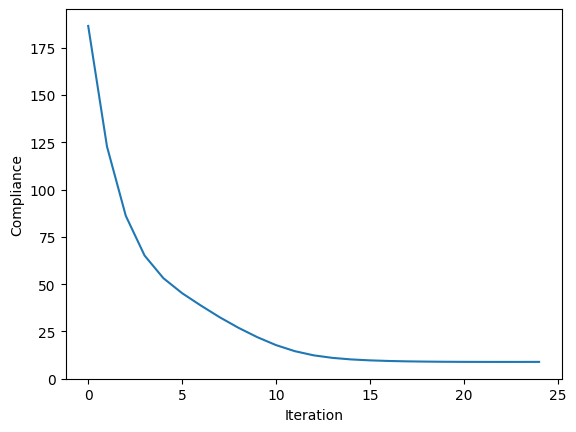

In [11]:
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Compliance")
plt.show()

In [12]:
from torchfem.io import export_mesh

rho_final = torch.ones(len(elements))
rho_final[dom == 6] = rho[-1]
export_mesh(
    model,
    "ge_bracket_topo.vtu",
    elem_data={"rho": [rho_final]},
    nodal_data={
        "u": u,
        "L1": load_case_1,
        "L2": load_case_2,
        "L3": load_case_3,
        "L4": load_case_4,
    },
)